<a href="https://colab.research.google.com/github/appleeye007/scalable_pink_team/blob/main/focus_Resnet14_Fitnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

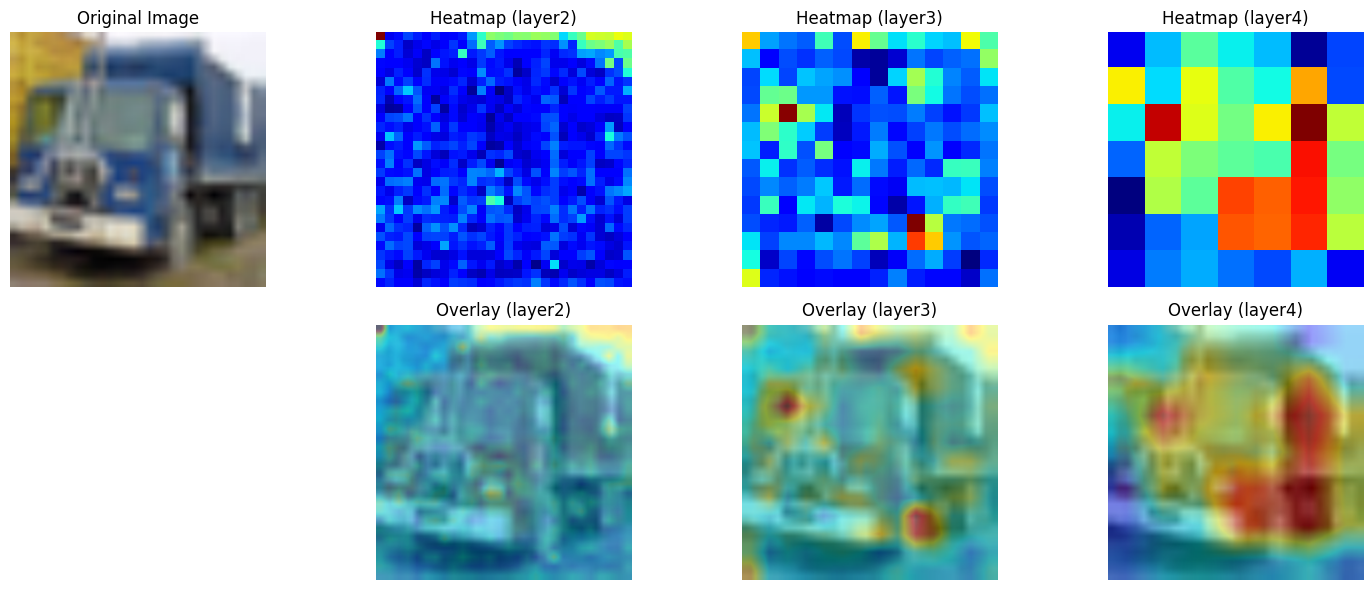

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torchvision import models



class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, 10)

    def forward(self, x, return_layer='layer2'):
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)
        x = self.resnet50.layer1(x)


        if return_layer == 'layer2':
            feature = self.resnet50.layer2(x)
            x = self.resnet50.layer3(feature)
            x = self.resnet50.layer4(x)
        elif return_layer == 'layer3':
            x = self.resnet50.layer2(x)
            feature = self.resnet50.layer3(x)
            x = self.resnet50.layer4(feature)
        elif return_layer == 'layer4':
            x = self.resnet50.layer2(x)
            x = self.resnet50.layer3(x)
            feature = self.resnet50.layer4(x)
        else:
            raise ValueError("return_layer must be 'layer2', 'layer3' or 'layer4'")


        if return_layer == 'layer4':
            x = self.resnet50.avgpool(feature)
            x = torch.flatten(x, 1)
            output = self.resnet50.fc(x)
        else:
            output = None

        return feature, output



def generate_heatmap(feature):
    feature = feature.squeeze(0)
    heatmap, _ = torch.max(feature, dim=0)
    heatmap = heatmap.cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-5)
    return heatmap


def overlay_heatmap_on_image(heatmap, original_tensor):
    image = transforms.ToPILImage()(original_tensor).convert("RGB").resize((224, 224))
    img_np = np.array(image)
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)
    return heatmap_resized, overlay


transform_vis = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_original = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_vis)
original_imgs = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_original)

input_tensor, _ = dataset[14]
img_tensor_for_vis, _ = original_imgs[14]
input_tensor = input_tensor.unsqueeze(0)


model = TeacherNet()
model.load_state_dict(torch.load('/content/teacher_layer2.pt', map_location='cpu'))
model.eval()


layers = ['layer2', 'layer3', 'layer4']
results = []

with torch.no_grad():
    for layer_name in layers:
        feature, output = model(input_tensor, return_layer=layer_name)
        heatmap = generate_heatmap(feature)
        resized_heatmap, overlay = overlay_heatmap_on_image(heatmap, img_tensor_for_vis)
        results.append((layer_name, heatmap, overlay))


plt.figure(figsize=(15, 6))
plt.subplot(2, len(results) + 1, 1)
plt.title("Original Image")
plt.imshow(np.transpose(img_tensor_for_vis.numpy(), (1, 2, 0)))
plt.axis('off')

for i, (layer_name, heatmap, overlay) in enumerate(results):
    plt.subplot(2, len(results) + 1, i + 2)
    plt.title(f"Heatmap ({layer_name})")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(2, len(results) + 1, i + 2 + len(results) + 1)
    plt.title(f"Overlay ({layer_name})")
    plt.imshow(overlay[:, :, ::-1])
    plt.axis('off')

plt.tight_layout()
plt.show()
